# House price prediction

On Tuesday, we used linear regression to predict house prices of the [California house price dataset](https://www.kaggle.com/camnugent/california-housing-prices). Our dataset contains 200 observations for housing blocks in California obtained from the 1990 census. The dataset contains columns:

1. `longitude`: A measure of how far west a house is; a higher value is farther west

2. `latitude`: A measure of how far north a house is; a higher value is farther north

3. `housing_median_age`: Median age of a house within a block; a lower number is a newer building

4. `total_rooms`: Total number of rooms within a block

5. `total_bedrooms`: Total number of bedrooms within a block

6. `population`: Total number of people residing within a block

7. `households`: Total number of households, a group of people residing within a home unit, for a block

8. `median_income`: Median income for households within a block of houses (measured in tens of thousands of US Dollars)

9. `median_house_value`: Median house value for households within a block (measured in US Dollars)

10. `ocean_proximity`: Location of the house w.r.t ocean/sea

Previously, we used intuition to guess what input variables would be suitable predictors. In this example, we are going to  use all the variables available and to predict `median_house_value`.

Load the file `housing.csv` and split it into training, validation and test datasets.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

#from plotnine import *

df = pd.read_csv("housing.csv")
df = df.dropna()         # Remove nans when using full dataset 
#df = shuffle(df)
training = df.iloc[:12259, :]
validation = df.iloc[12259:16346, :]
testing = df.iloc[16346:, :]
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


## Pytorch
We will use [pytorch](https://pytorch.org/tutorials/beginner/basics/intro.html) for this tutorial. Load the inputs and outputs as X, Y tensors

In [10]:
import torch

In [11]:
y = training["median_house_value"].values.reshape(-1, 1)
X = training[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
X.shape, y.shape 

((12259, 8), (12259, 1))

In [12]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_X.fit(X)
X_scaled = scaler_X.transform(X)

scaler_y = StandardScaler()
scaler_y.fit(y)
y_scaled = scaler_y.transform(y)

In [13]:
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

In [14]:
# Get the first batch
X_batch = X[0:64]
y_batch = y[0:64]

In [15]:
y_batch

tensor([[ 2.1295],
        [ 1.3089],
        [ 1.2530],
        [ 1.1588],
        [ 1.1667],
        [ 0.5344],
        [ 0.7917],
        [ 0.2876],
        [ 0.1594],
        [ 0.4594],
        [ 0.6373],
        [ 0.2911],
        [ 0.0443],
        [-0.1493],
        [-0.4293],
        [-0.5967],
        [-0.4877],
        [-0.4615],
        [-0.4336],
        [-0.3970],
        [-0.5313],
        [-0.4240],
        [-0.8243],
        [-0.9482],
        [-0.6613],
        [-0.8802],
        [-0.9996],
        [-0.8976],
        [-0.8680],
        [-0.6665],
        [-0.7511],
        [-0.8130],
        [-0.8549],
        [-0.9028],
        [-0.8610],
        [-0.9700],
        [-0.9063],
        [-0.9116],
        [-0.1485],
        [-0.2828],
        [-0.4624],
        [-0.5095],
        [-0.7816],
        [-0.1711],
        [-0.2095],
        [-0.2278],
        [-0.5749],
        [-0.6185],
        [-0.1825],
        [-0.8366],
        [-0.3185],
        [-0.9996],
        [-0.

Create a simple neural network. It can include as many or as few layers as you like. We will start simple with a 3-layer dense neural network, where we have an input layer, and 2 hidden layers with 16 nodes. For the input layer, we need to tell pytorch the number of input features (9). Then we can choose the number of hidden nodes. 

In [16]:
class SimpleNet(torch.nn.Module):
    def __init__(self, n_features=8, n_targets=1):
        super().__init__()
        self.n_features = n_features
        self.n_targets = n_targets
        
        self.layer_input = torch.nn.Linear(self.n_features, 16)         # Input layer: n_features -> 16
        self.layer_hidden1 = torch.nn.Linear(16, 16)                    # Hidden layer 1: 16 -> 16
        self.layer_hidden2 = torch.nn.Linear(16, self.n_targets)        # Hidden layer 2: 16 -> n_targets

        self.activation_function = torch.nn.ReLU()
        
    def forward(self, X):
        # Input layer
        output = self.layer_input(X)
        output = self.activation_function(output)
        
        # Hidden layer 1
        output = self.layer_hidden1(output)
        output = self.activation_function(output)

        # Hidden layer 2
        output = self.layer_hidden2(output)
        # Notice we don't use the activation function here - why not? when would we use it?
        
        return output

In [17]:
# Create an instance of SimpleNet and check we can call the function .forward on our first batch
my_network = SimpleNet(n_features=8, n_targets=1)
pred_batch = my_network(X_batch)
# Check the output is the correct size
print(pred_batch.shape)
assert(pred_batch.shape == y_batch.shape)

torch.Size([64, 1])


Decide on a suitable loss function. 

We will use Mean Squared Error (MSE). It is always good to check you can properly call this on your first batch of data.

In [18]:
loss_function = torch.nn.MSELoss()
loss_function(pred_batch, y_batch)

tensor(0.7302, grad_fn=<MseLossBackward0>)

And we also need to set up our optimiser and provide our network parameters

In [20]:
optimiser = torch.optim.SGD(params = my_network.parameters(), lr=0.1)

Great! We are ready to start our training loop. We could manually iterate through the data using indices, e.g., `X[0:64, :], y[0:64, :], ...`. But pytorch simplifies this for us with some useful functions, including mini-batching and shuffling - this will become essential when we move to large datasets. This is done in two steps, both of which are highly customisable. 
First, we create a `Dataset` which contains all of our data (you can also include any relevant pre-processing functions inside the Dataset). For regression, we provide our inputs and outputs. 
Then, we use a `DataLoader` that allows us to iterate through minibatches of data.

In [21]:
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, 
                                         shuffle=True,
                                         batch_size=64)

In [22]:
# Now we can iterate through the dataloader - check 
X_batch, y_batch = next(iter(dataloader))
X_batch.shape, y_batch.shape

(torch.Size([64, 8]), torch.Size([64, 1]))

In [23]:
losses = []

for X_batch, y_batch in dataloader:
    optimiser.zero_grad()
    pred_batch = my_network(X_batch)
    loss = loss_function(pred_batch, y_batch)
    loss.backward()

    # Update optimiser
    optimiser.step()

    # Add MSE losses to our list for plotting
    losses.append(loss.item())



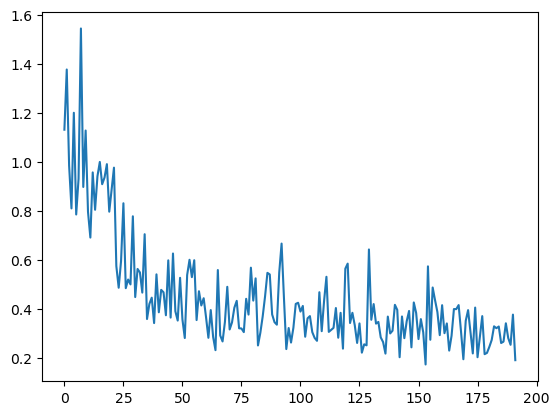

In [24]:
plt.plot(losses)

## Check validation dataset
Predict using the validation dataset and compare to the true validation dataset. Check our loss function (RMSE).


In [25]:
y_validation = validation["median_house_value"].values.reshape(-1, 1)
X_validation = validation[['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']].values
print(y_validation.shape, X_validation.shape)
X_validation_scaled = scaler_X.transform(X_validation)
y_validation_scaled = scaler_y.transform(y_validation)

X_validation = torch.tensor(X_validation_scaled, dtype=torch.float32)
y_validation = torch.tensor(y_validation_scaled, dtype=torch.float32)

dataset_validation = torch.utils.data.TensorDataset(X_validation, y_validation)
dataloader_validation = torch.utils.data.DataLoader(dataset_validation, 
                                         shuffle=True,
                                         batch_size=64)

(4087, 1) (4087, 8)


In [26]:
pred_validation = my_network(X_validation)
loss = loss_function(pred_validation, y_validation)
loss

tensor(0.3853, grad_fn=<MseLossBackward0>)

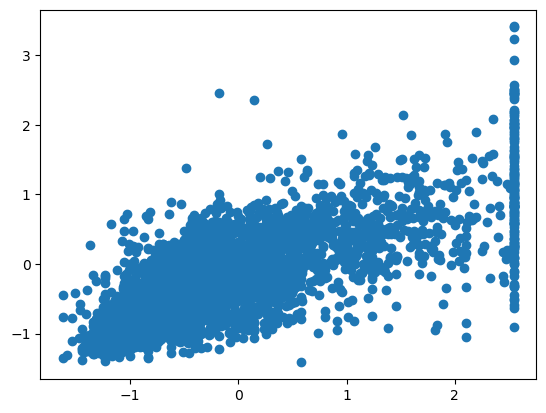

In [27]:
#plt.scatter(y, pred.detach().numpy())
plt.scatter(y_validation, pred_validation.detach().numpy())

How does it compare to your linear regression models on Tuesday? 



## Train over multiple epochs

Now you have gone through one full iteration of the data, train over multiple epochs and make sure you go through the validation dataset each epoch. Keep track of the training and validation losses averaged over each epoch separately and plot these.

In [28]:
len(dataloader), len(dataloader_validation)

(192, 64)

In [29]:
training_losses = []
validation_losses = []
num_epochs = 100


for epoch in range(num_epochs):
    my_network.train()
    training_loss = 0
    for X_batch, y_batch in dataloader:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch, y_batch)
        loss.backward()

        # Update optimiser
        optimiser.step()
        
        # Add loss to training_loss
        training_loss += loss.item()
        
    # Add MSE losses to our list for plotting
    training_loss = training_loss / len(dataloader)
    training_losses.append(training_loss)

    # validation
    my_network.eval()
    validation_loss = 0
    for X_batch, y_batch in dataloader_validation:
        optimiser.zero_grad()
        pred_batch = my_network(X_batch)
        loss = loss_function(pred_batch, y_batch)            
        # Add loss to validation_loss
        validation_loss += loss.item()
        
    
    # Add MSE losses to our list for plotting
    validation_loss = validation_loss / len(dataloader_validation)
    validation_losses.append(validation_loss)
    
    # After every 10 epochs print mean losses
    if epoch%10 ==0:
        print(f"After epoch {epoch}: Training loss={training_loss:.2f}, validation loss={validation_loss:.2f}")
              
              

After epoch 0: Training loss=0.31, validation loss=0.38
After epoch 10: Training loss=0.25, validation loss=0.33
After epoch 20: Training loss=0.23, validation loss=0.33
After epoch 30: Training loss=0.22, validation loss=0.37
After epoch 40: Training loss=0.22, validation loss=0.38
After epoch 50: Training loss=0.21, validation loss=0.32
After epoch 60: Training loss=0.21, validation loss=0.38
After epoch 70: Training loss=0.21, validation loss=0.34
After epoch 80: Training loss=0.20, validation loss=0.44
After epoch 90: Training loss=0.20, validation loss=0.32


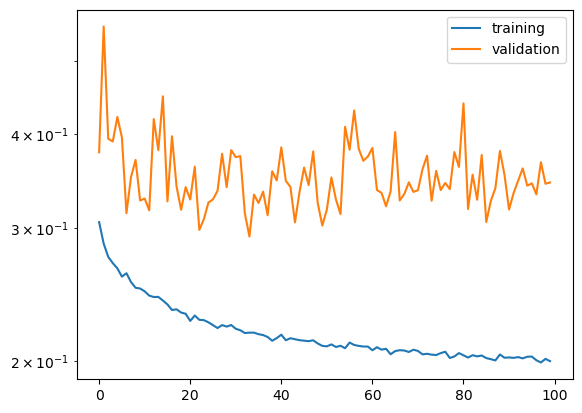

In [30]:
fig, ax = plt.subplots(1, 1)
plt.plot(training_losses, label="training")
plt.plot(validation_losses,  label="validation")
plt.legend()
ax.set_yscale('log')

## How to avoid overfitting?
Add more data
Repeat with full dataset, over many epochs. This should improve generalisation.
Keep an eye on your models as you train by plotting the training loss and the validation loss together.
Add things into loss function to reduce overfitting.

You could play around with different versions of the network. For example, try:
* More or fewer layers.
* More of fewer hidden nodes.
* Different choice of activation functions (...)
* Different choice of loss functions ( ... )
* Different choice of optimiser (...)

Selecting these choices for your problem is an optimisation problem in itself. This is often called hyperparameter selection. There is no best approach - usually people would manually search through some different options until we have the best results. There are some advanced "hyperparameter optimisation" packages (e.g., ...) that search across the full space of possible options.
